In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [3]:
np.random.seed(33)
torch.manual_seed(33)

In [4]:
# 數據生成：阻尼簡諧運動 (Damped Oscillator)
def physics_system(t):
    return np.exp(-0.2 * t) * np.cos(2 * np.pi * t)
total_time = 1000
t_all = np.linspace(0, 15, total_time)
data_raw = physics_system(t_all)

data_noisy = data_raw + np.random.normal(0, 0.02, size=total_time)

In [5]:
#Time Series Dataset (Sliding Window) ---
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 20
X_np, y_np = create_sequences(data_noisy, SEQ_LENGTH)

In [6]:

train_size = int(len(X_np) * 0.8)
X_train = torch.FloatTensor(X_np[:train_size]).unsqueeze(2) 
y_train = torch.FloatTensor(y_np[:train_size]).unsqueeze(1)
X_test = torch.FloatTensor(X_np[train_size:]).unsqueeze(2)
y_test = torch.FloatTensor(y_np[train_size:]).unsqueeze(1)

print(f"訓練集大小: {len(X_train)}, 測試集大小: {len(X_test)}")

訓練集大小: 784, 測試集大小: 196


In [7]:
#模型定義：LSTM vs MLP

# 模型 A: LSTM (專門處理時間序列)
class LSTMPredictor(nn.Module):
    def __init__(self):
        super(LSTMPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=32, num_layers=1, batch_first=True)
        self.linear = nn.Linear(32, 1)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_time_step = lstm_out[:, -1, :]
        return self.linear(last_time_step)

# 模型 B: 簡單 MLP (作為對照組)
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(SEQ_LENGTH, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

model_lstm = LSTMPredictor()
model_mlp = SimpleMLP()

In [8]:
def train_model(model, name, epochs=200):
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    losses = []
    print(f"正在訓練 {name}...")
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

loss_lstm = train_model(model_lstm, "LSTM Model")
loss_mlp = train_model(model_mlp, "MLP Model")

正在訓練 LSTM Model...
正在訓練 MLP Model...


In [9]:
model_lstm.eval()
model_mlp.eval()

with torch.no_grad():
    pred_lstm = model_lstm(X_test).numpy()
    pred_mlp = model_mlp(X_test).numpy()

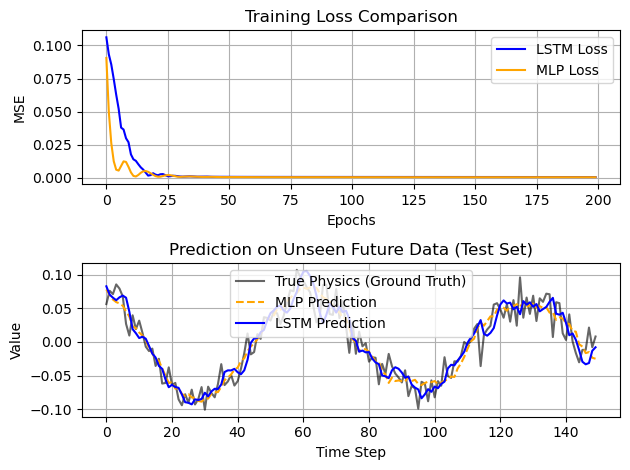

In [10]:
plt.subplot(2, 1, 1)
plt.plot(loss_lstm, label='LSTM Loss', color='blue')
plt.plot(loss_mlp, label='MLP Loss', color='orange')
plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
# 只畫測試集的一段，比較清楚
plot_len = 150
plt.plot(y_test.numpy()[:plot_len], 'k-', label='True Physics (Ground Truth)', alpha=0.6)
plt.plot(pred_mlp[:plot_len], 'orange', label='MLP Prediction', linestyle='--')
plt.plot(pred_lstm[:plot_len], 'blue', label='LSTM Prediction')

plt.title('Prediction on Unseen Future Data (Test Set)')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('final_project_result.png')
plt.show()